Import Statements

In [1]:
import numpy as np  
import pandas as pd  
from pandas_datareader import data as wb  
import matplotlib.pyplot as plt  
from scipy.stats import norm
%matplotlib inline

Get the past 10 years of stock price close data for Proctor & Gamble

In [2]:
ticker = 'EBAY' 
data = pd.DataFrame()
data[ticker] = wb.DataReader(ticker, data_source='yahoo', start='2010-1-1')['Adj Close']

Estimate historical log returns

In [3]:
log_returns = np.log(1 + data.pct_change())
log_returns.tail()

,EBAY
Date,
2020-08-04,-0.004252
2020-08-05,0.005841
2020-08-06,-0.028282
2020-08-07,0.002357
2020-08-10,-0.012393


Plot PG's price

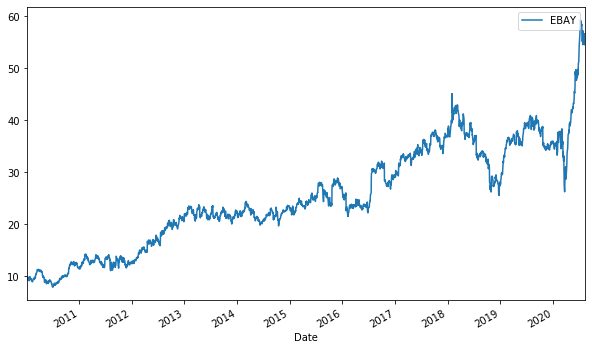

In [4]:
data.plot(figsize=(10, 6));

Plot log returns

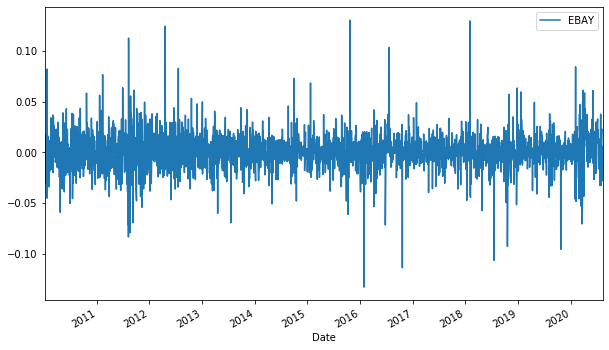

In [5]:
log_returns.plot(figsize = (10, 6))

find the mean

In [6]:
u = log_returns.mean()
u

EBAY    0.000642
dtype: float64

find the variance

In [7]:
var = log_returns.var()
var

EBAY    0.000334
dtype: float64

calculate the drift component for our geometric brownian motion model, mean - 1/2 variance

In [8]:
drift = u - (0.5 * var)
drift

EBAY    0.000475
dtype: float64

stddev of returns

In [9]:
stdev = log_returns.std()
stdev

EBAY    0.01828
dtype: float64

check that the types of our variables are pandas series

In [10]:
type(drift)

pandas.core.series.Series

In [11]:
type(stdev)

pandas.core.series.Series

convert pandas to np arrays

In [12]:
np.array(drift)

array([0.00047515])

In [13]:
drift.values

array([0.00047515])

works with stddev too

In [14]:
stdev.values

array([0.01828022])

function to find standard deviation of percent chance, for instance 95% chance (lower tail probability) is 1.65 standard deviations above the mean

In [15]:
norm.ppf(0.95)

1.6448536269514722

10x2 array of random numbers

In [16]:
x = np.random.rand(10, 2)
x

array([[0.13125408, 0.23706008],
       [0.81700303, 0.6613846 ],
       [0.28663656, 0.93062385],
       [0.46785603, 0.81975935],
       [0.21117857, 0.32134411],
       [0.84891846, 0.02170494],
       [0.0990249 , 0.49804693],
       [0.285849  , 0.19515483],
       [0.49015337, 0.38442682],
       [0.09437001, 0.73277698]])

pass the random numbers into the ppf function

In [17]:
norm.ppf(x)

array([[-1.12048261, -0.71579141],
       [ 0.90400274,  0.41624492],
       [-0.56323758,  1.48045332],
       [-0.08066036,  0.91444835],
       [-0.80233856, -0.46394352],
       [ 1.03180583, -2.01974473],
       [-1.28712762, -0.00489564],
       [-0.56555253, -0.85905594],
       [-0.02468434, -0.29387472],
       [-1.31431557,  0.62123344]])

call this a random variable denoted $Z$

In [18]:
Z = norm.ppf(np.random.rand(10,2))
Z

array([[ 0.59274285,  0.59276746],
       [-0.21387842,  0.0481202 ],
       [-0.994808  ,  0.11254059],
       [-1.00328345,  1.78588011],
       [ 1.27658272, -0.48906297],
       [-0.95859337, -0.93641471],
       [ 0.59168456, -1.11293929],
       [-0.83032852, -0.66961691],
       [-2.56242594,  1.70078445],
       [-0.7534036 ,  2.59961494]])

variables for the simulation

`t_intervals` is the number of days in the future

`iterations` is the number of times to simulate

In [19]:
t_intervals = 39
iterations = 1000000

matrix of daily returns = $e^{\text{drift} + \text{stddev} \cdot Z}$

In [20]:
daily_returns = np.exp(drift.values + stdev.values * norm.ppf(np.random.rand(t_intervals, iterations)))
daily_returns

array([[1.00463681, 1.02121279, 1.01568608, ..., 1.01064365, 1.01906935,
        0.98389753],
       [0.9973264 , 1.02204208, 1.02058191, ..., 0.99402496, 1.0131735 ,
        1.02223396],
       [1.02500525, 0.97176019, 1.00339391, ..., 1.02632205, 1.00045623,
        1.00336105],
       ...,
       [0.96523797, 0.98568622, 1.02325947, ..., 1.03812   , 0.99291575,
        0.99796597],
       [0.99803388, 0.99186617, 1.02158309, ..., 1.04125147, 1.0249219 ,
        0.99456357],
       [1.01156173, 0.97530222, 0.9836526 , ..., 0.98053155, 0.98571025,
        1.01137804]])

Each row represents a day, each column represents a simulation. The values are the daily returns for that day and simulation. $S_{t+1} = S_{t-1} \cdot r$. We set $S_0$ equal to the current stock price.

In [21]:
S0 = data.iloc[-1]
S0

EBAY    54.529999
Name: 2020-08-10 00:00:00, dtype: float64

create a new array with the same dimentions as `daily returns`

In [22]:
price_list = np.zeros_like(daily_returns)
price_list

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

set the first row (first day) of the simulation equal to the current price

In [23]:
price_list[0] = S0
price_list

array([[54.52999878, 54.52999878, 54.52999878, ..., 54.52999878,
        54.52999878, 54.52999878],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

simulate each day

In [24]:
for t in range(1, t_intervals):
    price_list[t] = price_list[t - 1] * daily_returns[t]

did it work?

In [25]:
price_list

array([[54.52999878, 54.52999878, 54.52999878, ..., 54.52999878,
        54.52999878, 54.52999878],
       [54.38420743, 55.73195335, 55.65233049, ..., 54.20417981,
        55.24834998, 55.74241646],
       [55.7440983 , 54.15809344, 55.84120967, ..., 55.63094496,
        55.27355609, 55.92976941],
       ...,
       [41.26815138, 52.96425161, 57.14420155, ..., 63.84747225,
        52.30211318, 60.82630542],
       [41.18701306, 52.53344944, 58.37754974, ..., 66.48127436,
        53.60558095, 60.49562746],
       [41.66320619, 51.23598969, 57.42322836, ..., 65.18698725,
        52.83957049, 61.18394911]])

plot the iterations if there aren't too many

In [26]:
if iterations <= 10000:
    plt.figure(figsize=(10,6))
    plt.plot(price_list);

the final prices after `t_intervals` days for each iteration

In [104]:
final_prices = price_list[-1]
final_prices

array([41.66320619, 51.23598969, 57.42322836, ..., 65.18698725,
       52.83957049, 61.18394911])

a histogram of the prices after `t_intervals` days

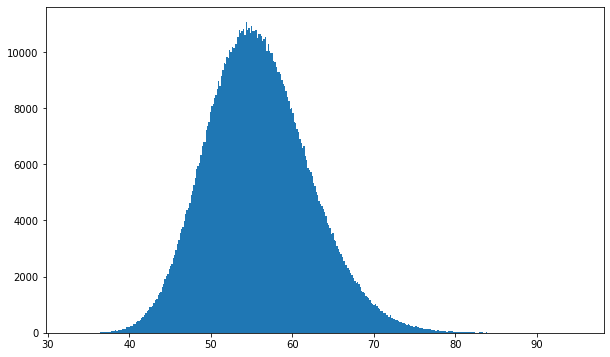

In [28]:
plt.figure(figsize=(10,6))
plt.hist(final_prices, bins='auto');

calculate the cumulative probability that the stock will be between two values

In [29]:
lb = -1
lb_inclusive = True
ub = 55
ub_inclusive = False

total_prices = 0
counted = 0
for price in final_prices:
    lb_condition = lb == -1 or price > lb
    ub_condition = ub == -1 or price < ub
    if lb_condition and ub_condition:
        counted += 1
    elif lb_inclusive and price == lb:
        counted += 1
    elif ub_inclusive and price == ub:
        counted += 1
    total_prices += 1

counted / total_prices

0.467621

class to represent a bundle of option contracts with a function to calculate the p/l at a given price

In [30]:
class OptionsStrategy:
    def __init__(self, contracts):
        self.contracts = contracts
        
    def reward(self, mkt):
        credit = -0.02

        for contract in self.contracts:
            if contract[0] == "LONG":
                credit -= contract[2]
                if contract[1] == "CALL" and mkt > contract[3]:
                    credit += mkt - contract[3]
                elif contract[1] == "PUT" and mkt < contract[3]:
                    credit += contract[3] - mkt
            elif contract[0] == "SHORT":
                credit += contract[2]
                if contract[1] == "CALL" and mkt > contract[3]:
                    credit -= mkt - contract[3]
                elif contract[1] == "PUT" and mkt < contract[3]:
                    credit -= contract[3] - mkt

        return credit

test a strategy

In [62]:
# ("LONG", "CALL", premium, strike)

trial_strategy = OptionsStrategy([
    ("SHORT", "PUT", 2.80, 55),
    ("LONG", "PUT", 0.87, 50)
])

plot the profit/loss diagram and breakeven point

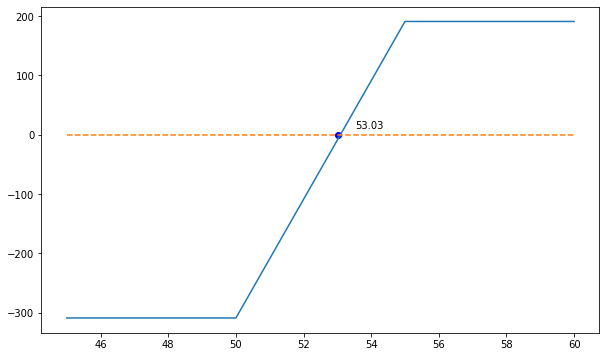

In [98]:
plt.figure(figsize=(10,6))
x = np.linspace(45, 60, 100)
breakeven_pl = 100
breakeven_price = 0
y = []
for xi in x:
    reward_i = trial_strategy.reward(xi) * 100
    y.append(reward_i)
    if abs(reward_i) < breakeven_pl:
        breakeven_price = xi
        breakeven_pl = abs(reward_i)
plt.annotate("{:.2f}".format(breakeven_price), (breakeven_price + 0.5, 10))
plt.plot(breakeven_price, 0, 'bo')
plt.plot(x, y);
plt.plot(x, [0]*len(x), '--');

calculate ev of the strategy

In [99]:
granularity = len(final_prices)

ev = 0
max_risk = 0
prob_success = 0
for price in final_prices:
    reward = trial_strategy.reward(price) * 100
    ev += reward / granularity
    if reward > 0:
        prob_success += 1
    if -1 * reward > max_risk:
        max_risk = -1 * reward
    
ev

33.8125239353625

capital risked

In [100]:
max_risk

309.00000000000006

expected return on capital risked

In [101]:
ev / max_risk

0.10942564380376212

probability of success

In [102]:
prob_success / granularity

0.653802